<a href="https://colab.research.google.com/github/MonikSense/GLAUCOMA/blob/main/Paper2Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== MODEL PERFORMANCE SUMMARY ===

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.784615   0.666667  0.352941  0.461538  0.788909
1                  SVM  0.776923   0.647059  0.323529  0.431373  0.740349
2        Decision Tree  0.646154   0.357143  0.441176  0.394737  0.579963
3        Random Forest  0.669231   0.371429  0.382353  0.376812  0.674479
4    Gradient Boosting  0.753846   0.538462  0.411765  0.466667  0.735141
5      Voting Ensemble  0.707692   0.428571  0.352941  0.387097  0.697763


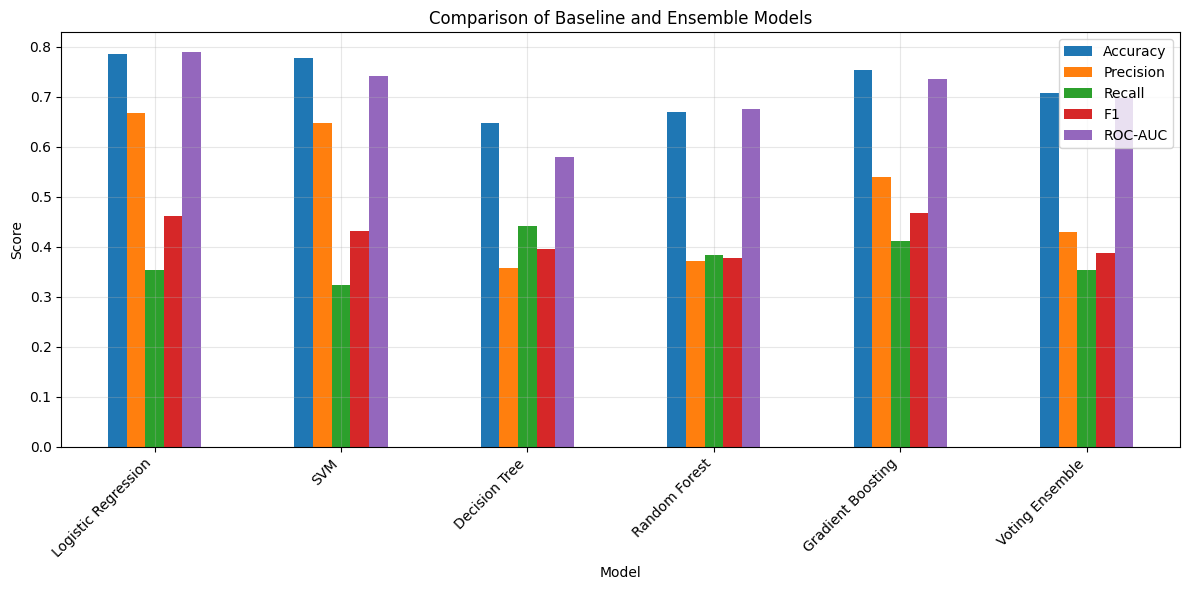

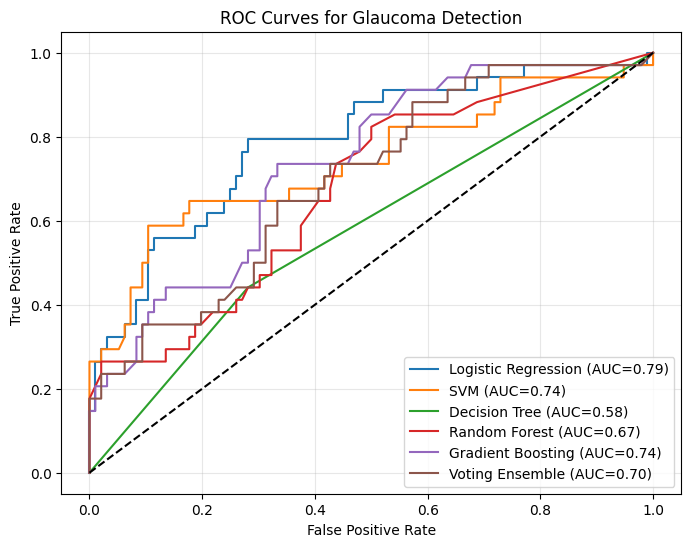

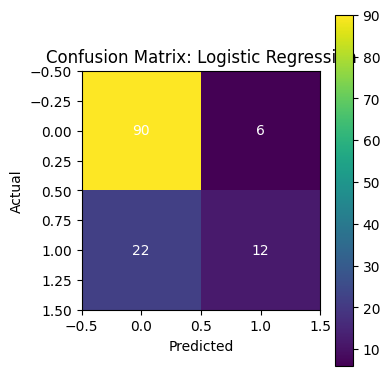

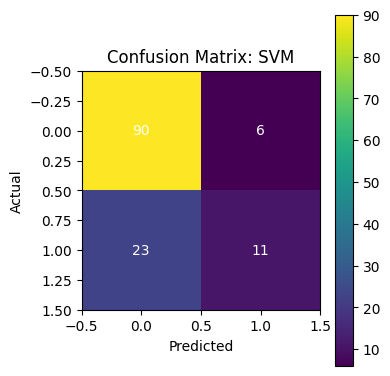

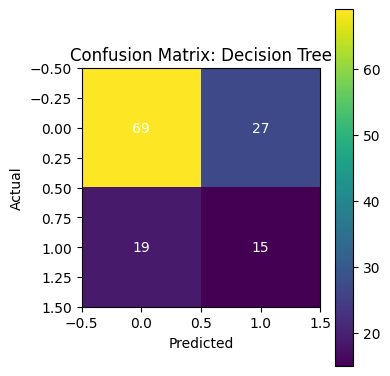

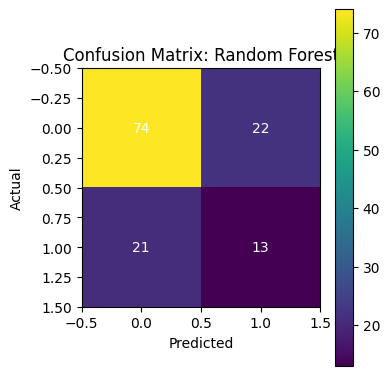

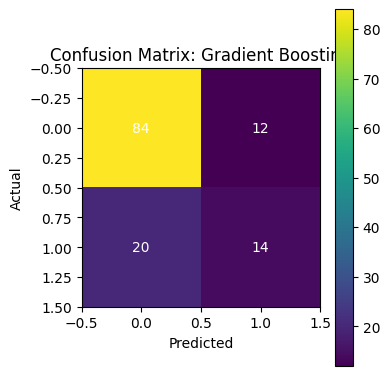

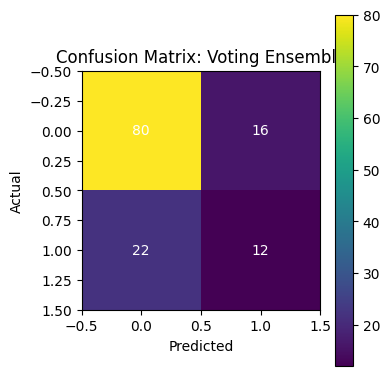

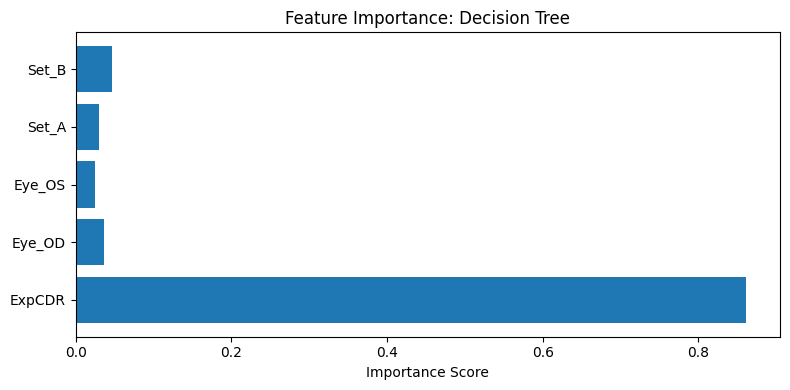

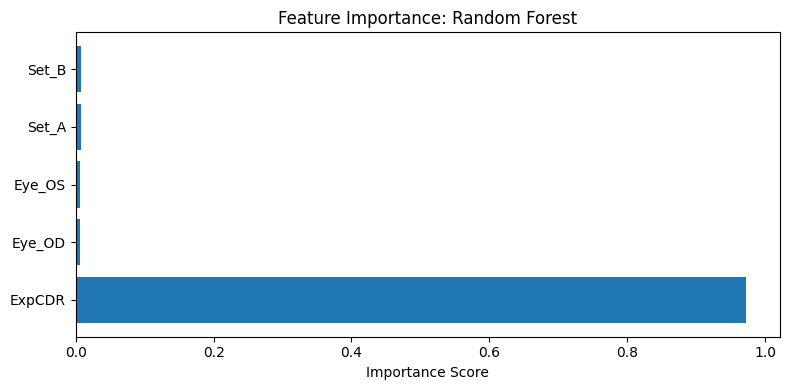

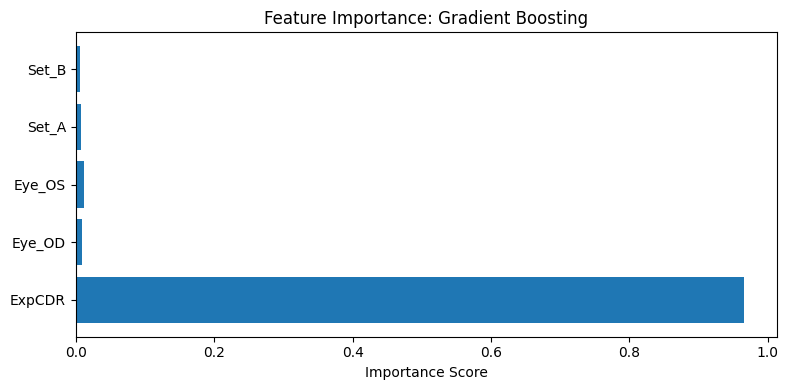


=== BEST MODEL CLASSIFICATION REPORT ===
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.94      0.87        96
           1       0.67      0.35      0.46        34

    accuracy                           0.78       130
   macro avg       0.74      0.65      0.66       130
weighted avg       0.77      0.78      0.76       130



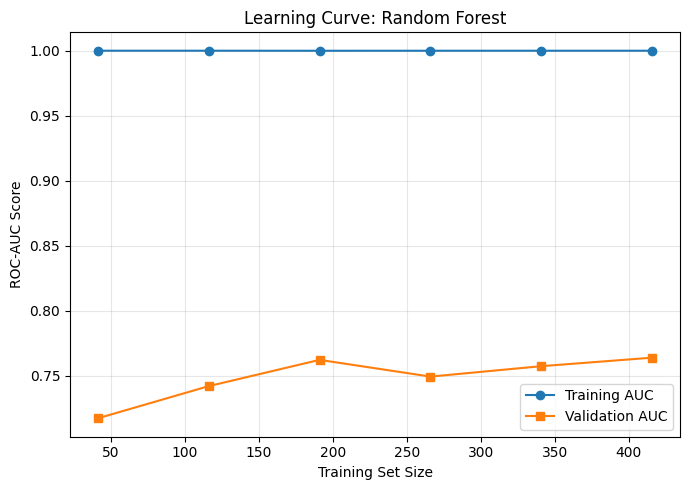

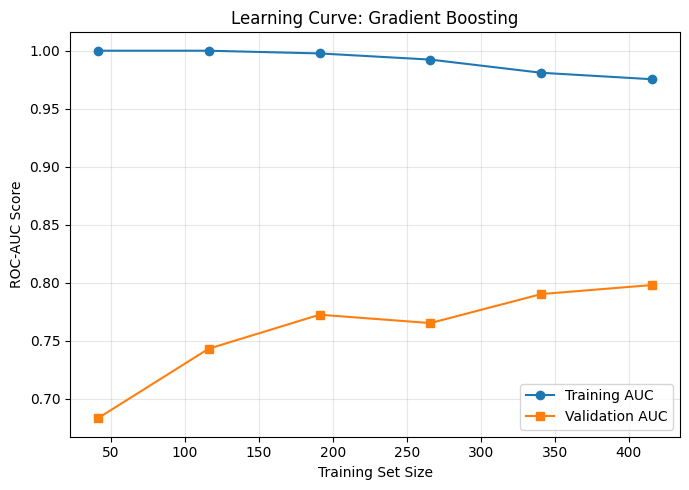

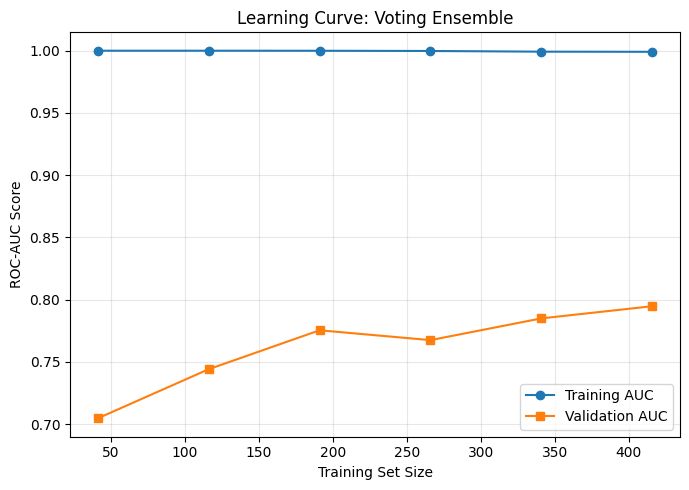

In [5]:
# ============================================================
# Objective 2: Feature Extraction & Ensemble Learning
# Application: Glaucoma Detection
# Models: Baseline + Ensemble (RF, GB, Voting)
# ============================================================
!pip install shap

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

# ============================================================
# 1. LOAD DATASET
# ============================================================

url = "https://raw.githubusercontent.com/MonikSense/GLAUCOMA/refs/heads/main/glaucoma.csv"
df = pd.read_csv(url)

df = df.drop(columns=["Filename"])

X = df.drop("Glaucoma", axis=1)
y = df["Glaucoma"]

numeric_features = ["ExpCDR"]
categorical_features = ["Eye", "Set"]

# ============================================================
# 2. PREPROCESSING PIPELINE
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================================================
# 3. MODEL DEFINITIONS
# ============================================================

baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

ensemble_models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

ensemble_models["Voting Ensemble"] = VotingClassifier(
    estimators=[
        ("rf", ensemble_models["Random Forest"]),
        ("gb", ensemble_models["Gradient Boosting"])
    ],
    voting="soft"
)

# ============================================================
# 4. TRAINING & EVALUATION FUNCTION
# ============================================================

def evaluate_model(name, model):
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "y_pred": y_pred,
        "y_prob": y_prob,
        "pipeline": pipe
    }

    return metrics

# ============================================================
# 5. RUN ALL MODELS
# ============================================================

results = []

for name, model in {**baseline_models, **ensemble_models}.items():
    results.append(evaluate_model(name, model))

results_df = pd.DataFrame(results).drop(columns=["y_pred", "y_prob", "pipeline"])

print("\n=== MODEL PERFORMANCE SUMMARY ===\n")
print(results_df)

# ============================================================
# 6. PERFORMANCE BAR PLOTS (PAPER FIGURE 1)
# ============================================================

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

results_df.set_index("Model")[metrics_to_plot].plot(
    kind="bar",
    figsize=(12,6)
)

plt.ylabel("Score")
plt.title("Comparison of Baseline and Ensemble Models")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 7. ROC CURVES (PAPER FIGURE 2)
# ============================================================

plt.figure(figsize=(8,6))

for res in results:
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=f'{res["Model"]} (AUC={res["ROC-AUC"]:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Glaucoma Detection")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 8. CONFUSION MATRICES (PAPER FIGURE 3)
# ============================================================

for res in results:
    cm = confusion_matrix(y_test, res["y_pred"])

    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix: {res['Model']}")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="white")

    plt.tight_layout()
    plt.show()

# ============================================================
# 9. FEATURE IMPORTANCE (ENSEMBLES ONLY) – PAPER FIGURE 4
# ============================================================

for res in results:
    model = res["pipeline"].named_steps["model"]

    if hasattr(model, "feature_importances_"):
        feature_names = (
            numeric_features +
            list(
                res["pipeline"]
                .named_steps["preprocess"]
                .transformers_[1][1]
                .get_feature_names_out(categorical_features)
            )
        )

        importances = model.feature_importances_

        plt.figure(figsize=(8,4))
        plt.barh(feature_names, importances)
        plt.xlabel("Importance Score")
        plt.title(f"Feature Importance: {res['Model']}")
        plt.tight_layout()
        plt.show()

# ============================================================
# 10. CLASSIFICATION REPORT (TEXT FOR PAPER)
# ============================================================

best_model = max(results, key=lambda x: x["ROC-AUC"])

print("\n=== BEST MODEL CLASSIFICATION REPORT ===")
print("Model:", best_model["Model"])
print(classification_report(y_test, best_model["y_pred"]))

# ============================================================
# 11. LEARNING CURVES (PAPER FIGURE 5)
# ============================================================

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X_train,
        y_train,
        cv=5,
        scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 6),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, marker='o', label="Training AUC")
    plt.plot(train_sizes, val_mean, marker='s', label="Validation AUC")
    plt.xlabel("Training Set Size")
    plt.ylabel("ROC-AUC Score")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Learning curves for ENSEMBLE MODELS ONLY
for name, model in ensemble_models.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    plot_learning_curve(pipe, f"Learning Curve: {name}")



